<a href="https://colab.research.google.com/github/ProvenDruid/CNNs/blob/main/cnn_gaussFeatures_HardSoft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# NEW! for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

In [ ]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      chConv1=3
      chConv2=6
      kernel=(3,2)
      step=(2,3)
      padd=1
      pool=(2,2)
      # conv1
      self.conv1 = nn.Conv2d(1,chConv1,kernel,step,padding=padd)
      outC1W=np.floor((imgSize+2*padd-kernel[1])/step[1])+1     #46 -----> /poolSize(2)=23
      outC1H=np.floor((imgSize+2*padd-kernel[0])/step[0])+1     #31 -----> /poolSize(2)=15
      # output size: (91+2*1-3)/1 + 1 = 91
      PoolOutC1W=np.floor(outC1W/pool[0])
      PoolOutC1H=np.floor(outC1H/pool[1])

      # post-pooling: 91/2 = 45

      # conv2
      self.conv2 = nn.Conv2d(chConv1,chConv2,kernel,step,padding=padd)
      outC2W=np.floor((PoolOutC1W+2*padd-kernel[1])/step[1])+1
      outC2H=np.floor((PoolOutC1H+2*padd-kernel[0])/step[0])+1
      # output size: (45+2*1-3)/1 + 1 = 45
      PoolOutC2W=np.floor(outC2W/pool[0]).astype(int)
      PoolOutC2H=np.floor(outC2H/pool[1]).astype(int)
      # post-pooling: 45/2 = 22

      # fc1
      self.fc1 = nn.Linear(PoolOutC2W*PoolOutC2H*chConv2,50)

      # fc2 (output)
      self.fc2 = nn.Linear(50,1)

    def forward(self,x):
      # first conv-pool set
      conv1act = F.relu(self.conv1(x))
      x = F.avg_pool2d(conv1act,(2,2))

      # second conv-pool set
      conv2act = F.relu(self.conv2(x))
      x = F.avg_pool2d(conv2act,(2,2))

      # ANN part
      x = x.reshape(x.shape[0],-1)
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)

      return x,conv1act,conv2act

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

# test that the model runs and can compute a loss
X,y = next(iter(train_loader))
yHat,featmap1,featmap2 = net(X)
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 3, 46, 31])

Feature map after conv2
torch.Size([32, 6, 12, 6])


In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [ ]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

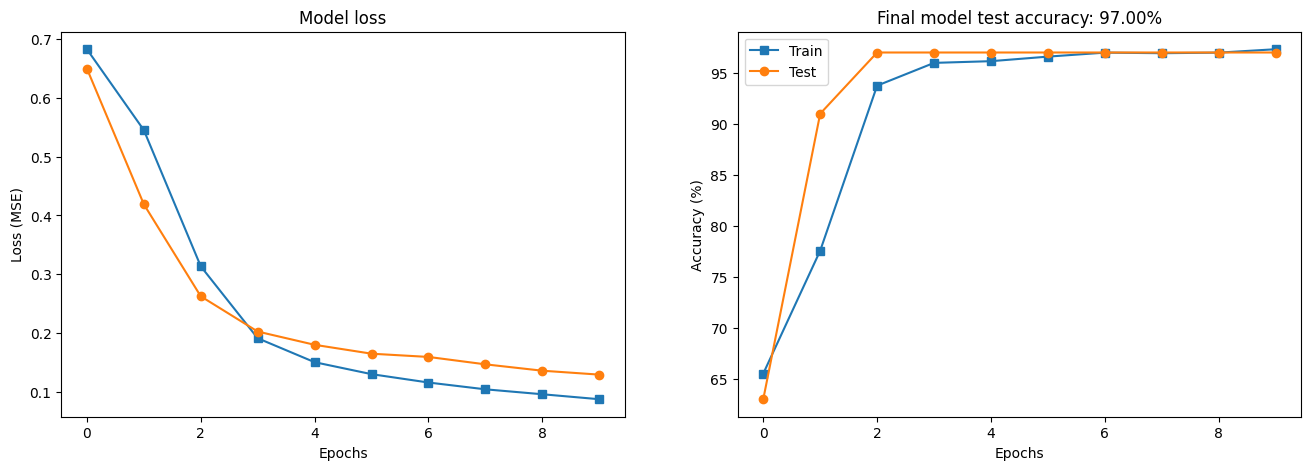

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()